In [12]:
import numpy as np
from skimage.feature import corner_harris, peak_local_max
import skimage.io as skio
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
from scipy.spatial import KDTree
import cv2
from scipy.signal import convolve2d
from scipy.spatial import distance_matrix
from scipy.ndimage import zoom, distance_transform_edt
from skimage.transform import resize


In [3]:
# SINGLE SCALE Harris Interest Point Detector

def get_harris_corners(im, edge_discard=20, threshold=0.1):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1,  threshold_abs=threshold)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)



def ANMS(H, coordinates, max_corners=1000):
    
    C_ROBUST = 0.9
   
   
    ### SORT THE COORDINATES FOR STRENGHT ### 
    x_coords, y_coords = coordinates
    
    strengths = H[x_coords, y_coords]

    # Sort strengths in descending order and get the sorted indices
    sorted_indices = np.argsort(-strengths) 

    sorted_x_coords = x_coords[sorted_indices]
    sorted_y_coords = y_coords[sorted_indices]

    sorted_strengths = strengths[sorted_indices]

    ### INITIALIZE TO KEEP TRACK OF SUPPRESSING RADIUSES ### 
    suppressing_radius_lst = np.full(len(sorted_x_coords), np.inf)

    sorted_coordinates = np.vstack((sorted_x_coords, sorted_y_coords)).T

    kd_tree = KDTree(sorted_coordinates)

    ## FOR EVERY CORNER IN DESCENDING MANNER BY THEIR STRENGTH
    for i, corner in enumerate(sorted_coordinates):

        radius_i = suppressing_radius_lst[i]

        ## ACCESS THEIR NEIGHBOURS WITHIN RADIUS
        neighbor_indices = kd_tree.query_ball_point(corner, r=radius_i)

        strength_i = sorted_strengths[i]

        ## IF THERE EXISTS NEIGHBOURS
        if len(neighbor_indices) > 1:  

            # remove self
            neighbor_indices = [j for j in neighbor_indices if j != i]  
            
            neighbor_coords = sorted_coordinates[neighbor_indices]

            current_corner = corner.reshape(1, -1)

            distances = dist2(current_corner, neighbor_coords)

            ## FOR EVERY NEIGHBOUR WITHIN THE RADIUS
            for j_idx, dist in zip(neighbor_indices, distances.flatten()):
                
                strength_j = sorted_strengths[j_idx] 
                
                ## IF THEY ARE STRONGER THAN SELF
                if strength_i < C_ROBUST * strength_j:

                    # UPDATE SELF'S RADIUS TO BE DIST
                    radius_i = min(radius_i, dist)

        ## REFLECT THE UPDATES ON RADIUS LIST
        suppressing_radius_lst[i] = radius_i

    final_sorted_indices = np.argsort(-suppressing_radius_lst)

    final_sorted_x_coords = sorted_x_coords[final_sorted_indices]
    final_sorted_y_coords = sorted_y_coords[final_sorted_indices]

    return final_sorted_x_coords[:max_corners], final_sorted_y_coords[:max_corners]





<>:48: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:48: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/15/mfxnc3cs6g38jn5cb27pgk_w0000gn/T/ipykernel_58515/3567703946.py:48: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


RETRIEVE AND DISPLAY HARRIS CORNERS 

In [98]:
imname = 'mutfak2.jpg'
im = imread(f'/Users/denizdemirtas/cs180/Project4/Part1/web/media/{imname}', as_gray=True)
im = normalize_image(im)

# Detect corners
h, coords = get_harris_corners(im, edge_discard=20, threshold=0.4)

# Display image and corners
fig, ax = plt.subplots(figsize=(im.shape[1] / 100, im.shape[0] / 100), dpi=100)
ax.imshow(im, cmap='gray')
ax.scatter(coords[1], coords[0], color='red', s=3)  
ax.set_title('Harris Corners')
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('') 


fig.canvas.draw()

plt.savefig(f'/Users/denizdemirtas/cs180/Project4/Part2/media/harris_corners_{imname}',transparent=True)

plt.close(fig)


# skio.imsave(f'/Users/denizdemirtas/cs180/Project4/Part2/media/harris_corners_{imname}', im)

In [118]:
# Display image and corners
imname = 'mutfak2.jpg'
im = imread(f'//Users/denizdemirtas/cs180/Project4/Part1/web/media/{imname}', as_gray=True)
im = normalize_image(im)

# Detect corners
h, coords = get_harris_corners(im, edge_discard=20, threshold=0.4)
s_corners = ANMS(h, coords, 400)


fig, ax = plt.subplots(figsize=(im.shape[1] / 100, im.shape[0] / 100), dpi=100)
ax.imshow(im, cmap='gray')
ax.scatter(coords[1], coords[0], color='red', s=4)  
ax.scatter(s_corners[1], s_corners[0], color='blue', s=4)  
ax.set_title('Harris Corners')
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('') 


fig.canvas.draw()

plt.savefig(f'/Users/denizdemirtas/cs180/Project4/Part2/media/ANMS_corners_{imname}',transparent=True)

plt.close(fig)


In [4]:
# Feature Descriptor 
def create_gaussian_filter(sigma=3):
    kernel_size = 6 * sigma + 1
    gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
    gaussian_filter = np.outer(gaussian_kernel, gaussian_kernel.T)
    return gaussian_filter

def create_gaussian_pyramid(image, level=4):
    
    if len(image.shape) == 2:  
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)

    pyramid_channels = []
    for channel in range(3):
        gaussian_channel = []
        current_image = image[:, :, channel]
        gaussian_channel.append(current_image)

        current_level = level
        while current_level > 0:
            
            gaussian_filter = create_gaussian_filter()
            blurred_image = convolve2d(current_image, gaussian_filter, mode='same', boundary='symm')
            blurred_image_downsize = resize(blurred_image, (blurred_image.shape[0] // 2, blurred_image.shape[1] // 2), anti_aliasing=True)
            gaussian_channel.append(blurred_image_downsize)
            current_image = blurred_image_downsize
            current_level -= 1

        pyramid_channels.append(gaussian_channel)

    return pyramid_channels


def downsample(image, downsample_factor=5):

    gaussian_filter = create_gaussian_filter()
    blurred_image = convolve2d(image, gaussian_filter, mode='same', boundary='symm')
    blurred_image_downsize = resize(blurred_image, (blurred_image.shape[0] // downsample_factor, blurred_image.shape[1] // downsample_factor), anti_aliasing=True)

    return blurred_image_downsize




def extract_patch(image, coordinate):

    x, y = coordinate
    
    ## FIND THE 40X40 PIXEL PATCH AROUND THESE COORDINATES
    patch = image[y-20: y + 20, x-20 : x+20]

    patch = downsample(patch)

    return patch


def extract_feature_patches(image, coordinates, save_path=None):


    corner_patches = {}

    for index, coordinate in enumerate(coordinates):

        patch = extract_patch(image, coordinate)


        if save_path and index == 1:

            skio.imsave(save_path, normalize_image(patch))

       ## Bias gain invariance -- SAVE BEFORE HERE
        patch_mean = np.mean(patch)
        patch_std = np.std(patch)

        if patch_std == 0:
            normalized_patch = patch - patch_mean
        else:
            normalized_patch = (patch - patch_mean) / patch_std

        corner_patches[index] = normalized_patch

    return corner_patches


        

In [5]:
# FEATURE MATCHING 

class DescriptorMatcher:
    
    def __init__(self, descriptors_dict):

        self.descriptors_dict = descriptors_dict
        self.descriptors = np.array(list(descriptors_dict.values()))
        self.coordinates = list(descriptors_dict.keys())
        self.num_descriptors = len(self.descriptors)

    def find_nn(self, query_descriptor, k=1):

        query_descriptor_flat = query_descriptor.flatten()

        # Flatten each descriptor in self.descriptors to create a list of 1D descriptors
        descriptors_flat = np.array([descriptor.flatten() for descriptor in self.descriptors])
        
        # Compute the distance matrix between the query descriptor and all stored descriptors
        distances = distance_matrix([query_descriptor_flat], descriptors_flat)[0]

        # Get the indices of sorted distances (in ascending order)
        sorted_indices = np.argsort(distances)

        # Find the k-th nearest neighbor
        kth_nn_idx = sorted_indices[k - 1]
        kth_nn_distance = distances[kth_nn_idx]

        return kth_nn_idx, kth_nn_distance

    def match_features(self, other_matcher, threshold=0.5):
        matches = {}

        for i, query_descriptor in self.descriptors_dict.items():
            
            # Find the 1st and 2nd nearest neighbors in the other matcher's descriptors
            nn_1_idx, nn_1_distance = other_matcher.find_nn(query_descriptor, k=1)
            _, nn_2_distance = other_matcher.find_nn(query_descriptor, k=2)

            # Calculate the 1-NN/2-NN ratio
            nn_ratio = nn_1_distance / nn_2_distance

            # Store the match if the ratio is below the threshold (indicating a good match)
            if nn_ratio < threshold:
                matches[self.coordinates[i]] = other_matcher.coordinates[nn_1_idx]

        return matches




In [6]:
# RANSAC HOMOGRAPHY GENERATION 

def computeH(im1_pts, im2_pts):

    im1_pts = np.asarray(im1_pts)
    im2_pts = np.asarray(im2_pts)
    
    num_points = im1_pts.shape[0]
    
    x1, y1 = im1_pts[:, 0], im1_pts[:, 1]
    x2, y2 = im2_pts[:, 0], im2_pts[:, 1]
    
    A = np.zeros((2 * num_points, 9))
    
    A[0::2, 0:3] = np.stack([-x1, -y1, -np.ones(num_points)], axis=1)
    A[0::2, 6:9] = np.stack([x2 * x1, x2 * y1, x2], axis=1)

    A[1::2, 3:6] = np.stack([-x1, -y1, -np.ones(num_points)], axis=1)
    A[1::2, 6:9] = np.stack([y2 * x1, y2 * y1, y2], axis=1)

    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :] / Vt[-1, -1] 
    
    H = h.reshape((3, 3))
    
    return H

def im_warp(im, H):
    height, width = im.shape[:2]
    channels = im.shape[2] if len(im.shape) == 3 else 1
    
    corners = np.array([[0, 0, 1], [width - 1, 0, 1], [width - 1, height - 1, 1], [0, height - 1, 1]]).T

    
    warped_corners = H @ corners
    warped_corners /= warped_corners[2, :]  


    min_x = int(np.floor(np.min(warped_corners[0, :])))
    max_x = int(np.ceil(np.max(warped_corners[0, :])))
    min_y = int(np.floor(np.min(warped_corners[1, :])))
    max_y = int(np.ceil(np.max(warped_corners[1, :])))
    
    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    xv, yv = np.meshgrid(x_range, y_range)
    
    target_coords = np.stack([xv.ravel(), yv.ravel(), np.ones_like(xv.ravel())], axis=0)
    
    H_inv = np.linalg.inv(H)
    source_coords = H_inv @ target_coords
    source_coords /= source_coords[2, :]  # Normalize homogeneous coordinates

    source_x = source_coords[0, :]
    source_y = source_coords[1, :]

    if channels == 1:
        warped_values = bilinear_interpolate(im, source_x, source_y)
        warped_image = warped_values.reshape(yv.shape)
    else:
        warped_values = bilinear_interpolate(im, source_x, source_y)
        warped_image = warped_values.reshape((yv.shape[0], yv.shape[1], channels))

    return warped_image


def bilinear_interpolate(im, x, y):
    height, width = im.shape[:2]
    channels = im.shape[2] if len(im.shape) == 3 else 1
    
    # Clip the coordinates to ensure they are within bounds
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1
    
    x0 = np.clip(x0, 0, width - 1)
    x1 = np.clip(x1, 0, width - 1)
    y0 = np.clip(y0, 0, height - 1)
    y1 = np.clip(y1, 0, height - 1)
    
    if channels == 1:
        top_left = im[y0, x0]   
        top_right = im[y0, x1]    
        bottom_left = im[y1, x0] 
        bottom_right = im[y1, x1] 
    else:
        top_left = im[y0, x0, :]     
        top_right = im[y0, x1, :]   
        bottom_left = im[y1, x0, :]  
        bottom_right = im[y1, x1, :] 
    
    # Calculate the weights for interpolation
    weight_top_left = (x1 - x) * (y1 - y)
    weight_top_right = (x - x0) * (y1 - y)
    weight_bottom_left = (x1 - x) * (y - y0)
    weight_bottom_right = (x - x0) * (y - y0)
    
    if channels == 1:
        return (weight_top_left * top_left + weight_top_right * top_right +
                weight_bottom_left * bottom_left + weight_bottom_right * bottom_right)
    else:
        return (weight_top_left[:, None] * top_left + weight_top_right[:, None] * top_right +
                weight_bottom_left[:, None] * bottom_left + weight_bottom_right[:, None] * bottom_right)



def RANSAC(matches_image1, matches_image2, err_thresh=3.5, max_iter=300):

    assert len(matches_image1) == len(matches_image2)

    # format : (inliers, h)
    best = ([], None)
    
    for iter in range(max_iter):

        random_indices = np.random.choice(len(matches_image1), size=4, replace=False)

        points1 = [matches_image1[i] for i in random_indices]
        points2 = [matches_image2[i] for i in random_indices]

        h = computeH(points1, points2)


        inliers = []

        for i, point in enumerate(matches_image1):
            
            # Convert point to homogeneous coordinates
            point_homogeneous = np.array([point[0], point[1], 1])
            
            projected_point = np.dot(h, point_homogeneous)
            projected_point /= projected_point[2]  

            # Get the corresponding point from matches_image2
            corresponding_point = matches_image2[i]

            # Compute the Euclidean distance between the projected point and the corresponding point
            distance = np.linalg.norm(np.array([projected_point[0], projected_point[1]]) - np.array(corresponding_point))

            if distance < err_thresh:
                inliers.append(i)
            
        
        if len(inliers) > len(best[0]):
            best = (inliers, h)

    final_inliers_indices = best[0]
    final_inliers_im1 = [matches_image1[i] for i in final_inliers_indices]
    final_inliers_im2 = [matches_image2[i] for i in final_inliers_indices]

    final_h = computeH(final_inliers_im1, final_inliers_im2)

    return final_h


def normalize_image(im):
    # Normalize image values to the range 0-255
    im_min = np.min(im)
    im_max = np.max(im)
    normalized_im = (im - im_min) / (im_max - im_min) * 255
    return normalized_im.astype(np.uint8)
    



In [11]:
## MATCH VISUALIZER

def display_matches(image1, image2, keypoints1, keypoints2):

    # keypoints1, keypoints2 = process_matches(matches, selected_corner_coordinates_im1, selected_corner_coordinates_im2)

    concatenated_image = np.concatenate((image1, image2), axis=1)
    # concatenated_image = image1

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(concatenated_image)

    offset = image1.shape[1]

    for (x1,y1), (x2,y2) in zip(keypoints1, keypoints2):
        
        # x1, y1 = corner_coordinates_im1[idx1]
        # x2, y2 = corner_coordinates_im2[idx2]

        ax.scatter([x1], [y1], color='blue', s=10) 
        ax.scatter([x2 + offset], [y2], color='blue', s=10) 

        ax.plot([x1, x2 + offset], [y1, y2], color='red', linewidth=1)


    ax.set_xlim(0, concatenated_image.shape[1])
    ax.set_ylim(concatenated_image.shape[0], 0) 

    ax.set_axis_off() 
    plt.tight_layout()
    plt.show()


def process_matches(matches, selected_corner_coordinates_im1, selected_corner_coordinates_im2):

    matched_coords_im1 = []
    matched_coords_im2 = []

    for idx1, idx2 in matches.items():
        matched_coords_im1.append(selected_corner_coordinates_im1[idx1])
        matched_coords_im2.append(selected_corner_coordinates_im2[idx2])

    return matched_coords_im1, matched_coords_im2



def create_gaussian_pyramid(image, level=4):
    
    if len(image.shape) == 2:  # If grayscale, convert to 3 channels
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)

    pyramid_channels = []
    for channel in range(3):
        gaussian_channel = []
        current_image = image[:, :, channel]
        gaussian_channel.append(current_image)

        current_level = level
        while current_level > 0:
            
            gaussian_filter = create_gaussian_filter()
            blurred_image = convolve2d(current_image, gaussian_filter, mode='same', boundary='symm')
            blurred_image_downsize = resize(blurred_image, (blurred_image.shape[0] // 2, blurred_image.shape[1] // 2), anti_aliasing=True)
            gaussian_channel.append(blurred_image_downsize)
            current_image = blurred_image_downsize
            current_level -= 1

        pyramid_channels.append(gaussian_channel)

    return pyramid_channels


def create_laplacian_pyramid(gaussian_pyramid):
    
    laplacian_channels = []

    for channel in range(3):
        laplacian_channel = []
        gp = gaussian_pyramid[channel]

        for i in range(len(gp) - 1):
            current_image = gp[i]
            next_image = gp[i + 1]
            
            next_image_upsampled = resize(next_image, (current_image.shape[0], current_image.shape[1]), anti_aliasing=True)
            high_freq = current_image - next_image_upsampled
            laplacian_channel.append(high_freq)

        laplacian_channel.append(gp[-1])  # The smallest level remains unchanged
        laplacian_channels.append(laplacian_channel)

    return laplacian_channels

def blend_laplacian_pyramids(mask_gaussian, image1_laplacian, image2_laplacian, save_dir="output", prefix="pyramid_level"):
    blended_channels = []
    
    image1_masked_pyramids = [[] for _ in range(3)]  
    image2_masked_pyramids = [[] for _ in range(3)]  

    for channel in range(3):
        blended_channel = []
        mask_gp = mask_gaussian[channel]
        lap1 = image1_laplacian[channel]
        lap2 = image2_laplacian[channel]

        level = 0
        while len(lap1) > 0:
            mask_level = mask_gp[0]
            image1_level = lap1[0]
            image2_level = lap2[0]

            image1_masked = mask_level * image1_level
            image2_masked = (1 - mask_level) * image2_level


            image1_masked_pyramids[channel].append(image1_masked)
            image2_masked_pyramids[channel].append(image2_masked)

            blended_level = image1_masked + image2_masked
            blended_channel.append(blended_level)

            mask_gp, lap1, lap2 = mask_gp[1:], lap1[1:], lap2[1:]
            level += 1

        blended_channels.append(blended_channel)

    # save_pyramid_levels(image1_masked_pyramids, prefix=f"{prefix}_debug_image1_masked")
    # save_pyramid_levels(image2_masked_pyramids, prefix=f"{prefix}_debug_image2_masked")

    return blended_channels

def reconstruct_blended_laplacian(laplacian_pyramid):
    reconstructed_channels = []

    for channel in range(3):
        laplacian_channel = laplacian_pyramid[channel]
        current_image = laplacian_channel[-1]

        for finer_image in reversed(laplacian_channel[:-1]):
            current_image_upsampled = zoom(current_image, 
                                           (finer_image.shape[0] / current_image.shape[0], 
                                            finer_image.shape[1] / current_image.shape[1]), 
                                           order=1)
            current_image = current_image_upsampled + finer_image

        reconstructed_channels.append(current_image)

    reconstructed_image = np.stack(reconstructed_channels, axis=-1)
    return reconstructed_image


def create_final_canvas(image1, image2, H):


    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]

    corners_img1 = np.array([
        [0, 0, 1],
        [w1, 0, 1],
        [w1, h1, 1],
        [0, h1, 1]
    ]).T

    # Warp the corners using the homography matrix
    warped_corners_img1 = np.dot(H, corners_img1)
    warped_corners_img1 /= warped_corners_img1[2, :]  # Normalize the homogeneous coordinates

    x_coords = warped_corners_img1[0, :]
    y_coords = warped_corners_img1[1, :]

    # Find the bounds of the warped image
    min_x = min(0, np.min(x_coords))
    max_x = max(w2, np.max(x_coords))
    min_y = min(0, np.min(y_coords))
    max_y = max(h2, np.max(y_coords))

    # Calculate the size of the final canvas
    canvas_width = int(np.ceil(max_x - min_x))
    canvas_height = int(np.ceil(max_y - min_y))

    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    offset = (int(-min_x), int(-min_y))

    return canvas, offset




def create_blending_mask_inclined_overlap(image1_canvas, image2_canvas):
    
    mask1 = np.any(image1_canvas != [0, 0, 0], axis=-1).astype(np.uint8)
    mask2 = np.any(image2_canvas != [0, 0, 0], axis=-1).astype(np.uint8)

    # Compute the overlap mask
    overlap_mask = (mask1 & mask2).astype(np.uint8)

    blending_mask = np.zeros_like(mask1, dtype=np.float32)

    blending_mask[mask1 > 0] = 1.0

    distance1 = distance_transform_edt(overlap_mask == 0)
    distance2 = distance_transform_edt(overlap_mask == 0)

    # Calculate the total distance across the overlap to normalize the gradient
    total_distance = distance1 + distance2

    epsilon = 1e-6
    total_distance[total_distance == 0] = epsilon

    # Create the gradient based on the distance to the boundaries
    overlap_gradient = distance2 / total_distance

    # Assign the gradient only to the overlapping region in the mask
    blending_mask[overlap_mask > 0] = overlap_gradient[overlap_mask > 0]

    blending_mask = smooth_overlap_boundary(blending_mask, overlap_mask)

    return blending_mask

def smooth_overlap_boundary(blending_mask, overlap_mask):

    overlap_coords = np.argwhere(overlap_mask > 0)

    min_y, min_x = overlap_coords.min(axis=0)
    max_y, max_x = overlap_coords.max(axis=0)

    # Create a 2D gradient across both dimensions in the overlap
    for y in range(min_y, max_y + 1):
        for x in range(min_x, max_x + 1):
            if overlap_mask[y, x] > 0:
                dist_y = (y - min_y) / (max_y - min_y + 1e-6)
                dist_x = (x - min_x) / (max_x - min_x + 1e-6)
                blending_mask[y, x] = 0.5 * (1 - dist_x) + 0.5 * (1 - dist_y) 

    return blending_mask


ROBUST HOMOPGRAPHY PIPELINE

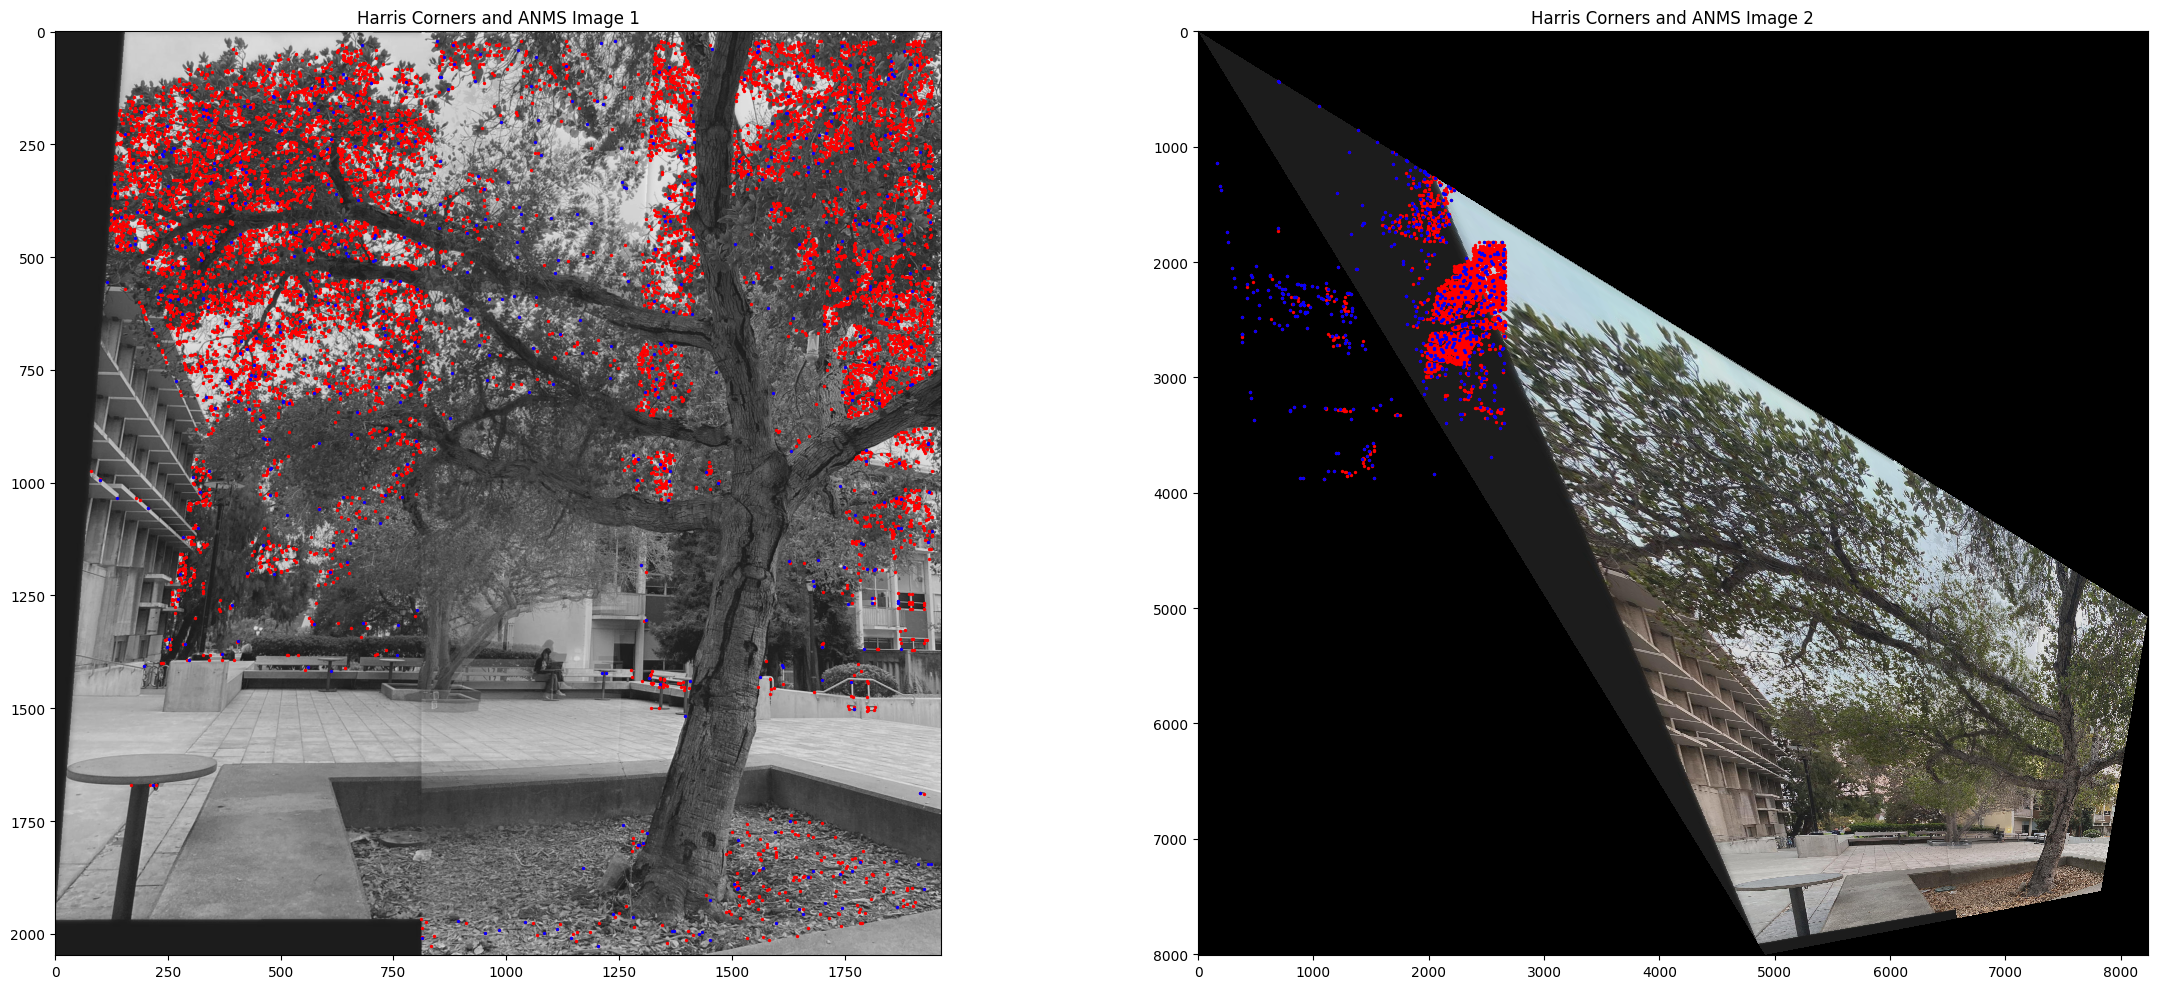

Blending mask created


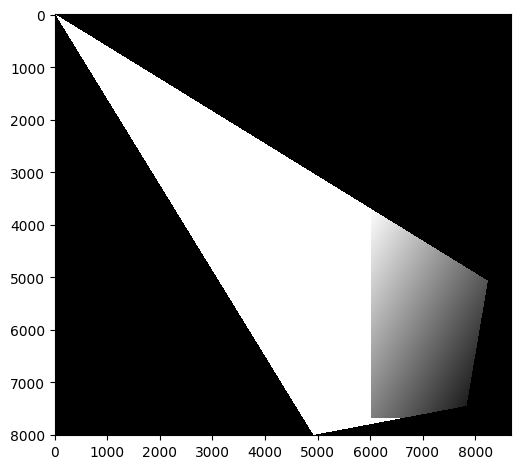

Mask gaussian created
Image 1 gaussian created
Image 2 gaussian created
Image 1 laplacian created
Image 2 laplacian created
Blended the laplacian pyramids


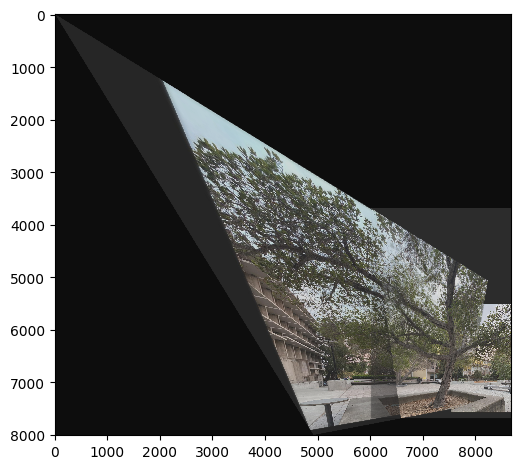

In [47]:
MAX_CORNER = 600

im1_path = '/Users/denizdemirtas/cs180/Project4/Part1/web/media'
im2_path = '/Users/denizdemirtas/cs180/Project4/Part1/web/media'

im1_name = 'alp_1-2.jpeg'
im2_name = 'alp_2-3.jpeg'

save_name = 'alp_1-3.jpeg'


im1 = imread(f'{im1_path}/{im1_name}', as_gray=True)
im2 = imread(f'/{im2_path}/{im2_name}', as_gray=True)


im1_color = imread(f'{im1_path}/{im1_name}')
im2_color = imread(f'{im2_path}/{im2_name}')



# Detect corners
h1, coords1 = get_harris_corners(im1, edge_discard=20, threshold=0.7)
h2, coords2 = get_harris_corners(im2, edge_discard=20, threshold=0.7)

# refine them with ANMS - hold on to refined corners 
selected_corners_im1 = ANMS(h1, coords1, MAX_CORNER)
selected_corners_im2 = ANMS(h2, coords2, MAX_CORNER)


fig, axes = plt.subplots(nrows=1, ncols=2,  figsize=(24, 10))


axes[0].imshow(im1, cmap='gray')
axes[0].scatter(coords1[1], coords1[0], color='red', s=2)  
axes[0].scatter(selected_corners_im1[1], selected_corners_im1[0], color='blue', s=2)  
axes[0].set_title('Harris Corners and ANMS Image 1')


axes[1].imshow(im2, cmap='gray')
axes[1].scatter(coords2[1], coords2[0], color='red', s=2)  
axes[1].scatter(selected_corners_im2[1], selected_corners_im2[0], color='blue', s=2)  
axes[1].set_title('Harris Corners and ANMS Image 2')


# (row, col) format the data
selected_corner_coordinates_im1 = list(zip(selected_corners_im1[1], selected_corners_im1[0]))
selected_corner_coordinates_im2 = list(zip(selected_corners_im2[1], selected_corners_im2[0]))


# for all (row, col) coordinates over the images, extract their patches in the format {index : patch}
selected_corner_patches_im1 = extract_feature_patches(im1, selected_corner_coordinates_im1)
selected_corner_patches_im2 = extract_feature_patches(im2, selected_corner_coordinates_im2)


# descriptors_im1 = np.array([patch.flatten() for patch in selected_corner_patches_im1])
# descriptors_im2 = np.array([patch.flatten() for patch in selected_corner_patches_im2])


matcher_im1 = DescriptorMatcher(selected_corner_patches_im1)
matcher_im2 = DescriptorMatcher(selected_corner_patches_im2)


matches_im1 = matcher_im1.match_features(matcher_im2, threshold=0.5)
matches_im2 = matcher_im2.match_features(matcher_im1, threshold=0.5)


match_coordinates_im1, match_coordinates_im2 = process_matches(matches_im1, selected_corner_coordinates_im1, selected_corner_coordinates_im2)

h = RANSAC(match_coordinates_im1, match_coordinates_im2)

rectified_image1 = normalize_image(im_warp(im1_color, h))

skio.imshow(rectified_image1)
skio.show()


# Create the final canvas dimensions (used for both images)
canvas, offset = create_final_canvas(im1, im2, h)
canvas_height, canvas_width = canvas.shape[:2]

offset_x, offset_y = offset

canvas1 = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
canvas2 = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

canvas2[offset_y:offset_y + im2_color.shape[0], offset_x:offset_x + im2_color.shape[1]] = im2_color

# Warp tower1_image to align with tower2_image (since tower2 is the stable reference plane)
# tower1_image_warped = im_warp(tower1_image, H)

coords_y, coords_x = np.indices(rectified_image1.shape[:2])
valid_x_mask = (coords_x >= 0) & (coords_x < canvas1.shape[1])
valid_y_mask = (coords_y >= 0) & (coords_y < canvas1.shape[0])
valid_mask = valid_x_mask & valid_y_mask
non_black_mask = ~np.all(rectified_image1 == [0, 0, 0], axis=-1)
final_mask = valid_mask & non_black_mask
canvas1[coords_y[final_mask], coords_x[final_mask]] = rectified_image1[final_mask]




mask = create_blending_mask_inclined_overlap(canvas1, canvas2)
print("Blending mask created")

skio.imshow(normalize_image(mask))
skio.show()

mask_gaussian = create_gaussian_pyramid(mask, 2)
print("Mask gaussian created")
im1_gaussian = create_gaussian_pyramid(canvas1, 2)
print("Image 1 gaussian created")
im2_gaussian = create_gaussian_pyramid(canvas2, 2)
print("Image 2 gaussian created")

im1_laplacian = create_laplacian_pyramid(im1_gaussian)
print("Image 1 laplacian created")
im2_laplacian = create_laplacian_pyramid(im2_gaussian)
print("Image 2 laplacian created")

blended_laplacian = blend_laplacian_pyramids(mask_gaussian, im1_laplacian, im2_laplacian)
print("Blended the laplacian pyramids")

blended_image = normalize_image(reconstruct_blended_laplacian(blended_laplacian))

skio.imshow(blended_image)
skio.show()


skio.imsave(f'/Users/denizdemirtas/cs180/Project4/Part1/web/media/{save_name}', blended_image)



In [41]:
matches_im2

{}

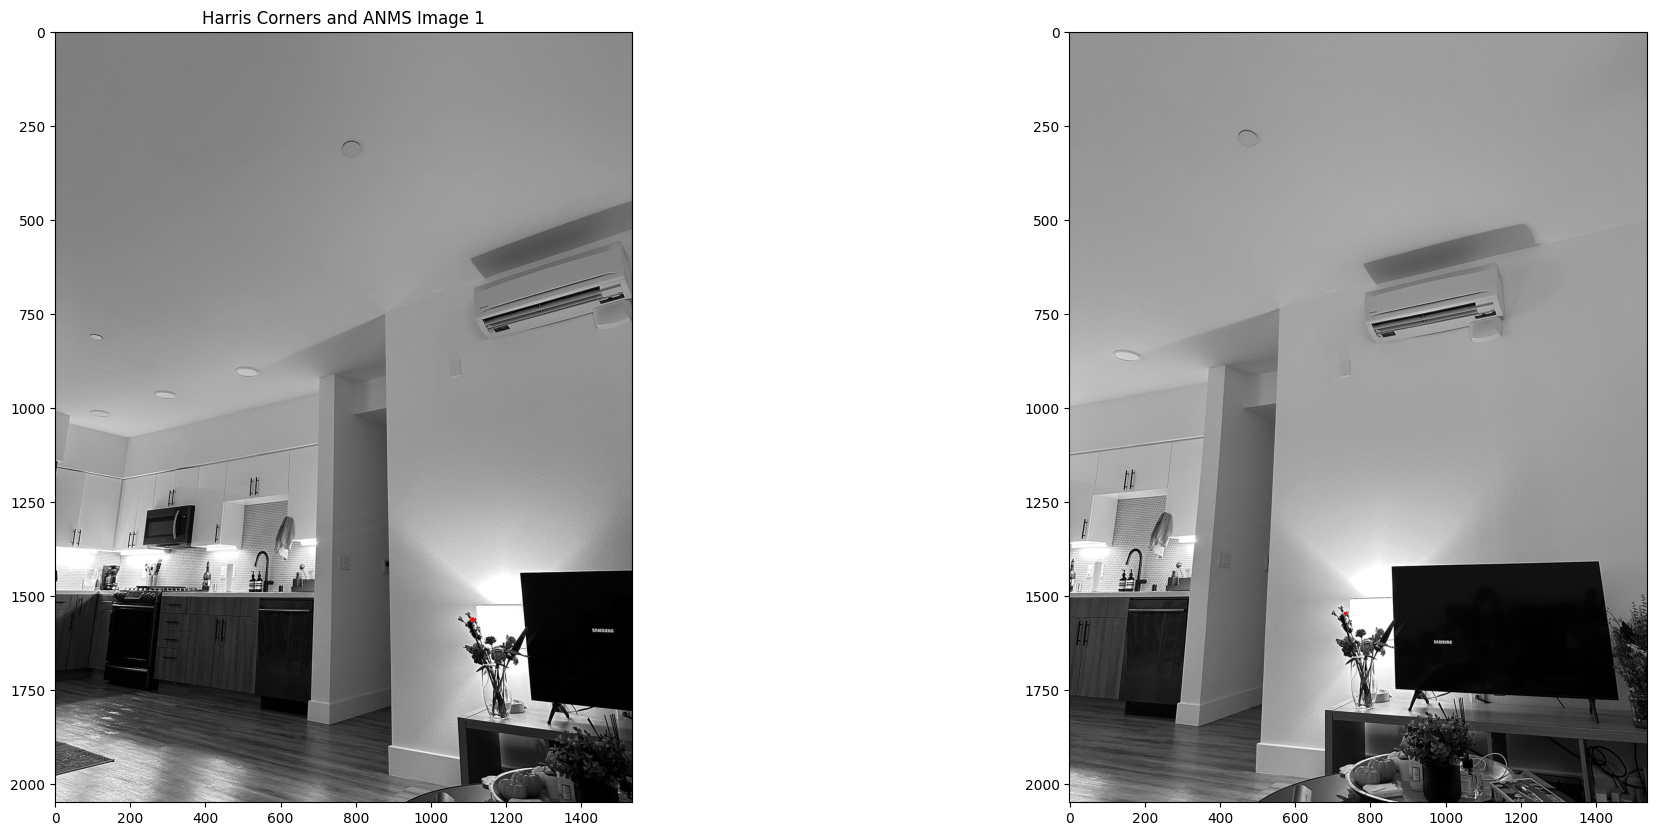

In [12]:
c1, c2 = process_matches(matches_im1, selected_corner_coordinates_im1, selected_corner_coordinates_im2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

x_coords_c1, y_coords_c1 = zip(*c1)
x_coords_c2, y_coords_c2 = zip(*c2)

axes[0].imshow(im1, cmap='gray')
axes[0].scatter(x_coords_c1[0], y_coords_c1[0], color='red', s=5)  
# axes[0].scatter(selected_corners_im1[1], selected_corners_im1[0], color='blue', s=2)  
axes[0].set_title('Harris Corners and ANMS Image 1')


axes[1].imshow(im2, cmap='gray')
axes[1].scatter(x_coords_c2[0], y_coords_c2[0], color='red', s=2)  
# # axes[1].scatter(selected_corners_im2[1], selected_corners_im2[0], color='blue', s=2)  
# axes[1].set_title('Harris Corners and ANMS Image 2')